## Languages Alignment

In [74]:
#import libraries
import numpy as np
import pandas as pd
import random
import gensim
from gensim.models import KeyedVectors
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
%matplotlib inline

### Read Vocabularies and Subset Bilingual Vocabularies
##### Big Files: do not run this it would take a while. 

In [2]:
#read source vocabulary (English)
source_vocabulary = KeyedVectors.load_word2vec_format('fastText/wiki.en.vec')

In [3]:
#read additional target vocabularies (Italian)
target_vocabulary = KeyedVectors.load_word2vec_format('fastText/wiki.it.vec')

In [4]:
#read additional target vocabularies (Portuguese)
target_vocabulary_1 = KeyedVectors.load_word2vec_format('fastText/wiki.pt.vec')

In [ ]:
#read additional target vocabularies (Russian)
target_vocabulary_2 = KeyedVectors.load_word2vec_format('fastText/wiki.ru.vec')

In [ ]:
#read additional target vocabularies (Japanese)
target_vocabulary_3 = KeyedVectors.load_word2vec_format('fastText/wiki.ja.vec')

In [ ]:
#read additional target vocabularies (Chinese)
target_vocabulary_4 = KeyedVectors.load_word2vec_format('fastText/wiki.zh.vec')

In [5]:
def toy_data(source_vocabulary, target_vocabulary, n_words):
    """Function to extract bilingual vocabulary from source and target vocabularies. It returns two dictionaries (i.e. source and target languages) with same keys."""

    #create a dictionary of overlapping words
    source_words = set(source_vocabulary.index2word)
    target_words = set(target_vocabulary.index2word)
    overlap = list(source_words & target_words)
    bilingual_vocabulary = [(entry, entry) for entry in overlap]
    
    #select a random number of words from the bilingual dictionary
    pair_words = random.sample(bilingual_vocabulary, n_words)
    toy_words = [tup[0] for tup in pair_words]
    
    #store vector for each word in two dictionaries (source and target)
    source_dictionary = dict()
    target_dictionary = dict()
    for word in toy_words:
        source_dictionary[word] = source_vocabulary.get_vector(str(word))
        target_dictionary[word] = target_vocabulary.get_vector(str(word))
    
    return source_dictionary, target_dictionary

In [16]:
#generate toy data eng_pt
source_dictionary, target_dictionary = toy_data(source_vocabulary, target_vocabulary_1, 100000)

In [14]:
# check lenght
len(source_dictionary.keys()) == len(target_dictionary.keys())

True

### Save and Load Data

In [17]:
# Save to file
np.save('toy_data_eng-pt_100000.npy', source_dictionary)
np.save('toy_data_pt-eng_100000.npy', target_dictionary)

In [2]:
# Read from file
dictionary_eng_pt = np.load('toy_data_eng-pt_20000.npy').item()
dictionary_pt_eng = np.load('toy_data_pt-eng_20000.npy').item()
#check if the words are the same in the two vocabulary
dictionary_eng_pt.keys() == dictionary_pt_eng.keys()

True

### Split Train and Test Data

In [3]:
def split_toy_data_train_test(source_dictionary, target_dictionary, ratio_train_test):
    """Function to split source and target dictionaries in train and test. It returns train and test matrices for both source and target languages."""
    #prepare the matrix
    source_matrix = list(source_dictionary.values())
    target_matrix = list(target_dictionary.values())
    
    #select split ratio and random indices
    indices = np.random.permutation(len(source_matrix))
    ratio_train_test = ratio_train_test
    split_range = int(len(source_matrix) * ratio_train_test)
    training_idx, test_idx = indices[:split_range], indices[split_range :]

    #select by indices train and test for source and target dictionaries
    source_train = np.array([source_matrix [i] for i in training_idx])
    source_test = np.array([source_matrix[i] for i in test_idx])
    target_train = np.array([target_matrix[i] for i in training_idx])
    target_test = np.array([target_matrix[i] for i in test_idx])
    
    return source_train, source_test, target_train, target_test

In [79]:
source_train, source_test, target_train, target_test = split_toy_data_train_test(dictionary_pt_eng, dictionary_eng_pt, 0.7)

In [80]:
print(source_train.shape, source_test.shape, target_train.shape, target_test.shape)

(14000, 300) (6000, 300) (14000, 300) (6000, 300)


### Learn Transformation to Align Languages

In [8]:
def normalized(a, axis=-1, order=2):
    """Utility function to normalize the rows of a numpy array."""
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    return a / np.expand_dims(l2, axis)

In [6]:
def learn_transformation(source_matrix, target_matrix, normalize_vectors=True):
    """
    Source and target matrices are numpy arrays, shape
    (dictionary_length, embedding_dimension). These contain paired
    word vectors from the bilingual dictionary.
    """
    # optionally normalize the training vectors
    if normalize_vectors:
        source_matrix = normalized(source_matrix)
        target_matrix = normalized(target_matrix)

    # perform the SVD
    product = np.matmul(source_matrix.transpose(), target_matrix)
    U, s, V = np.linalg.svd(product)

    # return orthogonal transformation which aligns source language to the target
    return np.matmul(U, V)

In [7]:
def apply_transform(transformation, source_test):
    """ Apply the given transformation to the vector space. 
    It returns predictions given transformations with embeddings E: E = E * transform """
    return np.matmul(source_test, transformation)

In [81]:
# learn the transformation
transformation = learn_transformation(source_train, target_train, normalize_vectors = False)
# apply transformation on the test of the source language
source_transformed = apply_transform(transformation, source_test)

### Evaluate Transformation

In [82]:
source_transformed.shape[0]

6000

In [83]:
def cosine_similarity(vec_a, vec_b):
    """Compute cosine similarity between vec_a and vec_b"""
    return np.dot(vec_a, vec_b) / \
        (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))

In [11]:
def evaluate_proximity(source_transformed, target_test, close_neighbors, metric):
    """Compute accuracy, cosine similarity and euclidian distance between the closest transformed vectors.
    INPUT:
    close_neighbors: choose number of neighbors
    metric: 'euclidian' or 'cosine' to compute kNN neighbors
    source_tranformed: test set of the source language after transformation
    target_test: test set of the target language
    
    OUTPUT:
    accuracy: percentage of matching words, within k neighbors, between source and target language after the alignment
    cosine_similarity: angolar distance among matching words
    l2_norm_distance: euclidian distance among matching words"""

    distance_embeddings = []
    accuracy = []
    similarity = []
    distance = []

    #fit model to find the closest vectors to tranformed one
    neighbors = NearestNeighbors(n_neighbors = close_neighbors, metric = metric)
    neighbors.fit(target_test)

    for i in range(0,source_transformed.shape[0]):
        index_transformed = i
        #distance between two vocabularies
        distance_embeddings.append(np.linalg.norm(source_transformed[i] - target_test[i]))
        #find vectors in the target vocabulary
        idx_neighbors_target = ((neighbors.kneighbors(source_transformed[index_transformed,:].reshape(1, -1)))[1][0]).tolist()
        #evaluate proximity among target and transformed vectors
        if index_transformed in idx_neighbors_target:
            accuracy.append('True')
            similarity.append(cosine_similarity(source_transformed[index_transformed], target_test[index_transformed]))
            distance.append(np.linalg.norm(source_transformed[index_transformed] - target_test[index_transformed]))
        else:
            accuracy.append('False')

    return [np.mean(distance_embeddings), round(accuracy.count('True')/len(accuracy)*100,2), np.mean(similarity), np.mean(distance)]

In [12]:
def evaluate(source_test, source_transformed, target_test):
    """Evalaute alignment comparing the source vocabulary and its transformed version with the target vocabulary.
    INPUT:
    source_test: vocabulary of the source language
    source_transformed: test set of the source language after transformation
    target_test: test set of the target language
    
    OUTPUT:
    dictionaries evaluating the alignment with different metrics"""
    
    sources = [source_test, source_transformed]
    metrics = ['cosine', 'euclidean']
    neighbors = [1,5,10]
    evaluation_before_cosine = dict()
    evaluation_before_euclidean = dict()
    evaluation_after_cosine = dict()
    evaluation_after_euclidean = dict()

    for source in sources:
        if source[0][0] == source_test[0][0]:
            for metric in metrics:
                if metric == 'cosine':
                    for neighbor in neighbors:
                        evaluation_before_cosine[neighbor] = evaluate_proximity(source_test, target_test, neighbor, 'cosine')

                else:
                    for neighbor in neighbors:
                        evaluation_before_euclidean[neighbor] = evaluate_proximity(source_test, target_test, neighbor, 'euclidean')

        else:
            for metric in metrics:
                if metric == 'cosine':
                    for neighbor in neighbors:
                        evaluation_after_cosine[neighbor] = evaluate_proximity(source_transformed, target_test, neighbor, 'cosine')

                else:
                    for neighbor in neighbors:
                        evaluation_after_euclidean[neighbor] = evaluate_proximity(source_transformed, target_test, neighbor, 'euclidean') 

    return evaluation_before_cosine, evaluation_before_euclidean, evaluation_after_cosine, evaluation_after_euclidean

In [84]:
#evaluate alignment source target
evaluation_before_cosine, evaluation_before_euclidean, evaluation_after_cosine, evaluation_after_euclidean = evaluate(source_test, source_transformed, target_test)

C:\Users\popor\AppData\Local\Continuum\anaconda3\envs\python3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\popor\AppData\Local\Continuum\anaconda3\envs\python3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [85]:
#set alignment evaluation table
index = ['distance_embeddings', 'accuracy', 'cosine_similarity', 'euclidean_distance']

#dump evaluation within dataframe
df_pt_eng = pd.DataFrame({'a': list(evaluation_before_cosine[1]),
                          'b': list(evaluation_after_cosine[1]),
                          'c': list(evaluation_before_euclidean[1]),
                          'd': list(evaluation_after_euclidean[1]),
                          
                          'e': list(evaluation_before_cosine[5]),
                          'f': list(evaluation_after_cosine[5]),
                          'g': list(evaluation_before_euclidean[5]),
                          'h': list(evaluation_after_euclidean[5]),
          
                          'i': list(evaluation_before_cosine[10]),
                          'l': list(evaluation_after_cosine[10]),
                          'm': list(evaluation_before_euclidean[10]),
                          'n': list(evaluation_after_euclidean[10])}, index=index)

#assign multilevel temporary columns name
columns=[('K@1','COSINE', 'a'),  ('K@1','COSINE', 'b'), ('K@1','EUCLIDEAN', 'c'),  ('K@1','EUCLIDEAN', 'd'),
   ('K@5','COSINE', 'e'),  ('K@5','COSINE', 'f'), ('K@5','EUCLIDEAN', 'g'),  ('K@5','EUCLIDEAN', 'h'),
    ('K@10','COSINE', 'i'),  ('K@10','COSINE', 'l'), ('K@10','EUCLIDEAN', 'm'),  ('K@10','EUCLIDEAN', 'n')]

#make multindex
df_pt_eng.columns= pd.MultiIndex.from_tuples(columns)

#change columns names
change_columns_name = ['non_tranformed','tranformed','non_tranformed','tranformed', 'non_tranformed','tranformed','non_tranformed','tranformed', 'non_tranformed','tranformed','non_tranformed','tranformed']
df_pt_eng.columns.set_levels(change_columns_name,level=2,inplace=True)
df_pt_eng

K@1                                       \
                            COSINE                 EUCLIDEAN              
                    non_tranformed tranformed non_tranformed tranformed   
distance_embeddings        6.97935   4.486204       6.979350   4.486204   
accuracy                   0.00000  61.730000       0.020000  35.630000   
cosine_similarity              NaN   0.620870      -0.048624   0.652534   
euclidean_distance             NaN   4.266411       3.258704   3.996814   

                               K@5                                       \
                            COSINE                 EUCLIDEAN              
                    non_tranformed tranformed non_tranformed tranformed   
distance_embeddings       6.979350   4.486204       6.979350   4.486204   
accuracy                  0.030000  79.500000       0.100000  53.420000   
cosine_similarity         0.175199   0.607791       0.007897   0.635990   
euclidean_distance        5.847142   4.346250       4.990319   4.085749   

                              K@10                                       
                            COSINE                 EUCLIDEAN             
                    non_tranformed tranformed non_tranformed tranformed  
distance_embeddings       6.979350   4.486204       6.979350   4.486204  
accuracy                  0.100000  84.850000       0.180000  60.280000  
cosine_similarity         0.163672   0.602409       0.022337   0.628767  
euclidean_distance        6.344755   4.372633       5.186204   4.127683

In [30]:
#output evaluation table
df_pt_eng

K@1                                       \
                            COSINE                 EUCLIDEAN              
                    non_tranformed tranformed non_tranformed tranformed   
distance_embeddings       6.960269   4.465349       6.960269   4.465349   
accuracy                  0.030000  60.530000       0.020000  47.520000   
cosine_similarity         0.192468   0.624186       0.030515   0.646520   
euclidean_distance        6.542164   4.264180       4.454175   4.115014   

                               K@5                                       \
                            COSINE                 EUCLIDEAN              
                    non_tranformed tranformed non_tranformed tranformed   
distance_embeddings       6.960269   4.465349       6.960269   4.465349   
accuracy                  0.120000  79.030000       0.120000  65.220000   
cosine_similarity         0.171238   0.610093       0.040887   0.631336   
euclidean_distance        6.249800   4.330600       5.378512   4.198347   

                              K@10                                       
                            COSINE                 EUCLIDEAN             
                    non_tranformed tranformed non_tranformed tranformed  
distance_embeddings       6.960269   4.465349       6.960269   4.465349  
accuracy                  0.130000  84.550000       0.180000  71.100000  
cosine_similarity         0.162262   0.604449       0.038368   0.624230  
euclidean_distance        6.335183   4.354204       5.200187   4.235862

In [86]:
#save evaluation table to csv
df_pt_eng.to_csv('evaluation_pt_eng_20k.csv')

In [32]:
#read evaluation
df = pd.read_csv('evaluation_eng_pt_20k.csv', header=[0,1,2], tupleize_cols=True)
df.columns = pd.MultiIndex.from_tuples(df.columns)
df.reset_index(drop=True)

C:\Users\popor\AppData\Local\Continuum\anaconda3\envs\python3\lib\site-packages\pandas\io\parsers.py:813: FutureWarning: The 'tupleize_cols' argument has been deprecated and will be removed in a future version. Column tuples will then always be converted to MultiIndex.


  self.options, self.engine = self._clean_options(options, engine)


Unnamed: 0_level_0            K@1                                       \
    Unnamed: 0_level_1         COSINE                 EUCLIDEAN              
    Unnamed: 0_level_2 non_tranformed tranformed non_tranformed tranformed   
0  distance_embeddings       6.960269   4.465349       6.960269   4.465349   
1             accuracy       0.030000  60.530000       0.020000  47.520000   
2    cosine_similarity       0.192468   0.624186       0.030515   0.646520   
3   euclidean_distance       6.542164   4.264180       4.454175   4.115014   

             K@5                                                K@10  \
          COSINE                 EUCLIDEAN                    COSINE   
  non_tranformed tranformed non_tranformed tranformed non_tranformed   
0       6.960269   4.465349       6.960269   4.465349       6.960269   
1       0.120000  79.030000       0.120000  65.220000       0.130000   
2       0.171238   0.610093       0.040887   0.631336       0.162262   
3       6.249800   4.330600       5.378512   4.198347       6.335183   

                                        
                  EUCLIDEAN             
  tranformed non_tranformed tranformed  
0   4.465349       6.960269   4.465349  
1  84.550000       0.180000  71.100000  
2   0.604449       0.038368   0.624230  
3   4.354204       5.200187   4.235862

In [67]:
def evaluate_rotation(source_test, source_transformed, target_test):
    """Evalaute rotation comparing: 1) the source vocabulary and its transformed version;
                                    2) source vocabulary transformed and the target vocabulary;
                                    3) source and target vocabularies;
    INPUT:
    source_test: vocabulary of the source language
    source_transformed: test set of the source language after transformation
    target_test: test set of the target language
    
    OUTPUT:
    euclidian distance and cosine similarity for each rotation comparison"""

    distance_source_target = []
    distance_source_transformed = []
    distance_transformed_target = []
    similarity_source_target = []
    similarity_source_transformed = []
    similarity_transformed_target = []

    for i in range(0,source_test.shape[0]):
        distance_source_target.append(np.linalg.norm(source_test[i] - target_test[i]))
        distance_source_transformed.append(np.linalg.norm(source_test[i] - source_transformed[i]))
        distance_transformed_target.append(np.linalg.norm(source_transformed[i] - target_test[i]))

        similarity_source_target.append(cosine_similarity(target_test[i],source_test[i]))
        similarity_source_transformed.append(cosine_similarity(source_test[i], source_transformed[i]))
        similarity_transformed_target.append(cosine_similarity(source_transformed[i], target_test[i]))

    return distance_source_target, distance_source_transformed, distance_transformed_target, similarity_source_target, similarity_source_transformed, similarity_transformed_target

In [87]:
# evalutate rotation
distance_source_target, distance_source_transformed, distance_transformed_target, similarity_source_target, similarity_source_transformed, similarity_transformed_target = evaluate_rotation(source_test, source_transformed, target_test)

In [88]:
# store output evaluation rotation in a dictionary
output_evaluation_rotation = {'distance_source_target':distance_source_target, 
                              'distance_source_transformed': distance_source_transformed, 
                              'distance_transformed_target': distance_transformed_target, 
                              'similarity_source_target': similarity_source_target, 
                              'similarity_source_transformed': similarity_source_transformed, 
                              'similarity_transformed_target': similarity_transformed_target}

In [89]:
#rememeber first language is the target, second the source
# save evaluation results 
import pickle
with open('output_evaluation_rotation_pt_eng', 'wb') as f:
    pickle.dump(output_evaluation_rotation, f)

In [70]:
# load evaluation results
with open('output_evaluation_rotation_eng_pt', 'rb') as f:
     data = pickle.load(f)

In [71]:
data.keys()

dict_keys(['distance_source_target', 'distance_source_transformed', 'distance_transformed_target', 'similarity_source_target', 'similarity_source_transformed', 'similarity_transformed_target'])

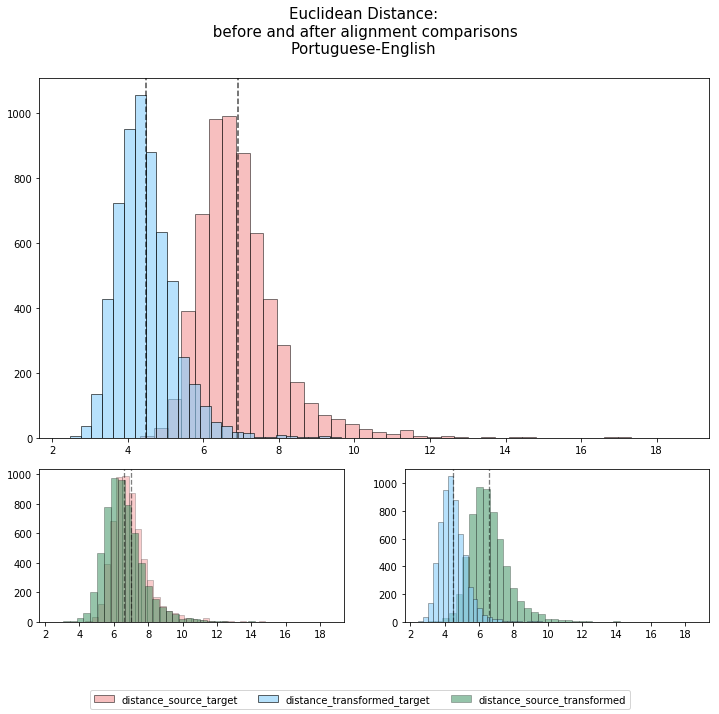

In [90]:
# Plot euclidian distances comparison pt-eng
fig = plt.figure(figsize=(12, 10))
grid = plt.GridSpec(24, 4, hspace=0.5, wspace=0.5)
main_ax = fig.add_subplot(grid[:16, 0:])
x1_hist = fig.add_subplot(grid[-7:, :2], sharex=main_ax)
x2_hist = fig.add_subplot(grid[-7:, 2:], sharex=main_ax)

main_ax.hist(distance_source_target, 
             color = "lightcoral", bins=40, alpha=.5, 
             edgecolor='black', linewidth=1, label='distance_source_target')
main_ax.hist(distance_transformed_target, 
             color = "lightskyblue", bins=40, alpha=0.6, 
             edgecolor='black', linewidth=1, label='distance_transformed_target')
main_ax.axvline(np.mean(distance_source_target)-.05, color='black',alpha=0.7, linestyle='dashed', linewidth=1.5)
main_ax.axvline(np.mean(distance_transformed_target), color='black',alpha=0.7, linestyle='dashed', linewidth=1.5)
#main_ax.annotate(str(round(np.mean(distance_transformed_target),2)), xy=(2, 820), xytext=(4.55, 815))

#ok
x1_hist.hist(distance_source_target, 
             color = "lightcoral", bins=40, alpha=0.4, 
             edgecolor='black', linewidth=.5) #, label='source_target'
x1_hist.hist(distance_source_transformed, 
             color = "seagreen", bins=40, alpha=0.5, 
             edgecolor='black', linewidth=.5, label='distance_source_transformed')
x1_hist.axvline(np.mean(distance_source_target), color='black',alpha=0.5, linestyle='dashed', linewidth=1.3)
x1_hist.axvline(np.mean(distance_source_transformed), color='black',alpha=0.5, linestyle='dashed', linewidth=1.3)

x2_hist.hist(distance_source_transformed, 
             color = "seagreen", bins=40, alpha=0.5,
             edgecolor='black', linewidth=.5) #, label='source_transformed'
x2_hist.hist(distance_transformed_target, 
             color = "lightskyblue", bins=40, alpha=0.6, 
             edgecolor='black', linewidth=.5) #, label='transformed_target'
x2_hist.axvline(np.mean(distance_source_transformed), color='black',alpha=0.5, linestyle='dashed', linewidth=1.3)
x2_hist.axvline(np.mean(distance_transformed_target), color='black',alpha=0.5, linestyle='dashed', linewidth=1.3)

plt.figlegend(loc = 'lower center', ncol=3, labelspacing=0.5) #bbox_to_anchor=(1.1, 1.05)
plt.suptitle('Euclidean Distance:\n before and after alignment comparisons\nPortuguese-English', fontsize=15);

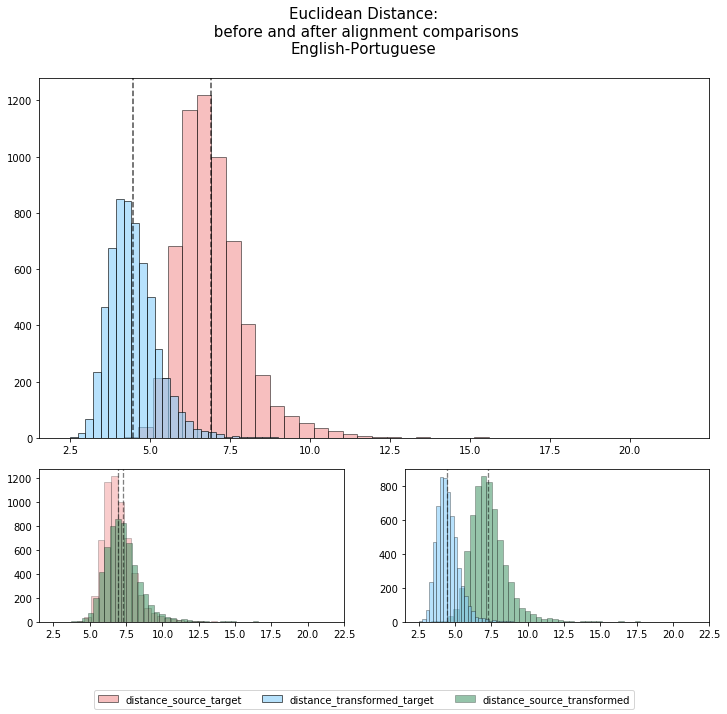

In [77]:
# Plot euclidian distances comparison eng-pt
fig = plt.figure(figsize=(12, 10))
grid = plt.GridSpec(24, 4, hspace=0.5, wspace=0.5)
main_ax = fig.add_subplot(grid[:16, 0:])
x1_hist = fig.add_subplot(grid[-7:, :2], sharex=main_ax)
x2_hist = fig.add_subplot(grid[-7:, 2:], sharex=main_ax)

main_ax.hist(distance_source_target, 
             color = "lightcoral", bins=40, alpha=.5, 
             edgecolor='black', linewidth=1, label='distance_source_target')
main_ax.hist(distance_transformed_target, 
             color = "lightskyblue", bins=40, alpha=0.6, 
             edgecolor='black', linewidth=1, label='distance_transformed_target')
main_ax.axvline(np.mean(distance_source_target)-.05, color='black',alpha=0.7, linestyle='dashed', linewidth=1.5)
main_ax.axvline(np.mean(distance_transformed_target), color='black',alpha=0.7, linestyle='dashed', linewidth=1.5)
#main_ax.annotate(str(round(np.mean(distance_transformed_target),2)), xy=(2, 820), xytext=(4.55, 815))

#ok
x1_hist.hist(distance_source_target, 
             color = "lightcoral", bins=40, alpha=0.4, 
             edgecolor='black', linewidth=.5) #, label='source_target'
x1_hist.hist(distance_source_transformed, 
             color = "seagreen", bins=40, alpha=0.5, 
             edgecolor='black', linewidth=.5, label='distance_source_transformed')
x1_hist.axvline(np.mean(distance_source_target), color='black',alpha=0.5, linestyle='dashed', linewidth=1.3)
x1_hist.axvline(np.mean(distance_source_transformed), color='black',alpha=0.5, linestyle='dashed', linewidth=1.3)

x2_hist.hist(distance_source_transformed, 
             color = "seagreen", bins=40, alpha=0.5,
             edgecolor='black', linewidth=.5) #, label='source_transformed'
x2_hist.hist(distance_transformed_target, 
             color = "lightskyblue", bins=40, alpha=0.6, 
             edgecolor='black', linewidth=.5) #, label='transformed_target'
x2_hist.axvline(np.mean(distance_source_transformed), color='black',alpha=0.5, linestyle='dashed', linewidth=1.3)
x2_hist.axvline(np.mean(distance_transformed_target), color='black',alpha=0.5, linestyle='dashed', linewidth=1.3)

plt.figlegend(loc = 'lower center', ncol=3, labelspacing=0.5) #bbox_to_anchor=(1.1, 1.05)
plt.suptitle('Euclidean Distance:\n before and after alignment comparisons\nEnglish-Portuguese', fontsize=15);

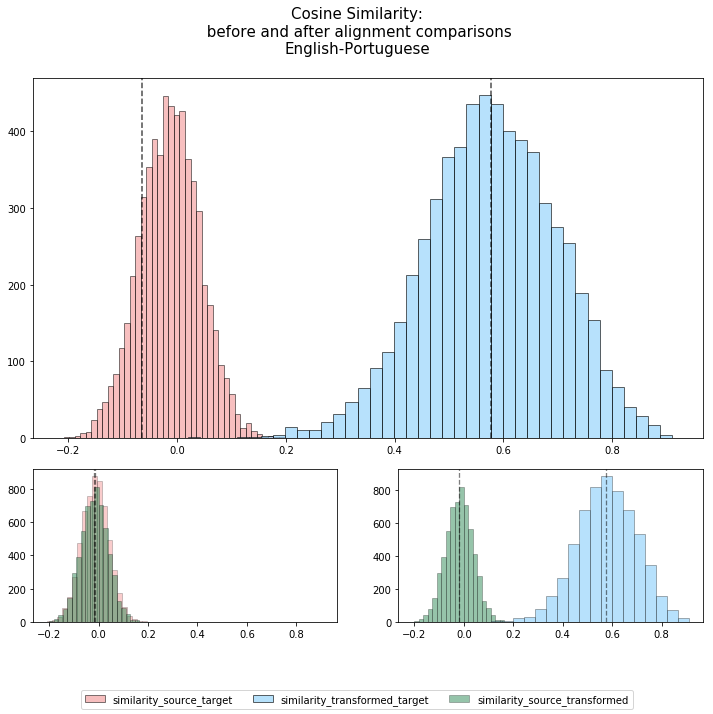

In [78]:
# Plot cosine similarities distances
fig = plt.figure(figsize=(12, 10))
grid = plt.GridSpec(24, 4, hspace=0.5, wspace=0.5)
main_ax = fig.add_subplot(grid[:16, 0:])
x1_hist = fig.add_subplot(grid[-7:, :2], sharex=main_ax)
x2_hist = fig.add_subplot(grid[-7:, 2:], sharex=main_ax)

main_ax.hist(similarity_source_target, 
             color = "lightcoral", bins=40, alpha=.5, 
             edgecolor='black', linewidth=1, label='similarity_source_target')
main_ax.hist(similarity_transformed_target, 
             color = "lightskyblue", bins=40, alpha=0.6, 
             edgecolor='black', linewidth=1, label='similarity_transformed_target')
main_ax.axvline(np.mean(similarity_source_target)-.05, color='black',alpha=0.7, linestyle='dashed', linewidth=1.5)
main_ax.axvline(np.mean(similarity_transformed_target), color='black',alpha=0.7, linestyle='dashed', linewidth=1.5)
#main_ax.annotate(str(round(np.mean(distance_transformed_target),2)), xy=(2, 820), xytext=(4.55, 815))

x1_hist.hist(similarity_source_target, 
             color = "lightcoral", bins=20, alpha=0.4, 
             edgecolor='black', linewidth=.5) #, label='source_target'
x1_hist.hist(similarity_source_transformed, 
             color = "seagreen", bins=20, alpha=0.5, 
             edgecolor='black', linewidth=.5, label='similarity_source_transformed')
x1_hist.axvline(np.mean(similarity_source_target), color='black',alpha=0.5, linestyle='dashed', linewidth=1.3)
x1_hist.axvline(np.mean(similarity_source_transformed), color='black',alpha=0.5, linestyle='dashed', linewidth=1.3)

x2_hist.hist(similarity_source_transformed, 
             color = "seagreen", bins=20, alpha=0.5,
             edgecolor='black', linewidth=.5) #, label='source_transformed'
x2_hist.hist(similarity_transformed_target, 
             color = "lightskyblue", bins=20, alpha=0.6, 
             edgecolor='black', linewidth=.5) #, label='transformed_target'
x2_hist.axvline(np.mean(similarity_source_transformed), color='black',alpha=0.5, linestyle='dashed', linewidth=1.3)
x2_hist.axvline(np.mean(similarity_transformed_target), color='black',alpha=0.5, linestyle='dashed', linewidth=1.3)

plt.figlegend(loc = 'lower center', ncol=3, labelspacing=0.5) #bbox_to_anchor=(1.1, 1.05)
plt.suptitle('Cosine Similarity:\n before and after alignment comparisons\nEnglish-Portuguese', fontsize=15);

### Plot t-sne (2D)

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Limit number of tokens to be visualized
limit = 150
vector_dim = 300

# Getting tokens and vectors
words = []
embedding = np.array([])
i = 0
for word in it_dictionary.vocab:
    # Break the loop if limit exceeds 
    if i == limit: break

    # Getting token 
    words.append(word)

    # Appending the vectors 
    embedding = np.append(embedding, it_dictionary[word])

    i += 1

# Reshaping the embedding vector 
embedding = embedding.reshape(limit, vector_dim)


def plot_with_labels(low_dim_embs, labels, filename='it_dictionary_tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
    plt.savefig(filename)


# Creating the tsne plot
tsne = TSNE(perplexity=30.0, n_components=2, init='pca', n_iter=5000)

low_dim_embedding = tsne.fit_transform(embedding)

# Finally plotting and saving the fig 
plot_with_labels(low_dim_embedding, words)

In [ ]:
# Limit number of tokens to be visualized
limit = 500
vector_dim = 300

# Getting tokens and vectors
words = []
embedding = np.array([])
i = 0
for word in eng_dictionary.vocab:
    # Break the loop if limit exceeds 
    if i == limit: break

    # Getting token 
    words.append(word)

    # Appending the vectors 
    embedding = np.append(embedding, eng_dictionary[word])

    i += 1

# Reshaping the embedding vector 
embedding = embedding.reshape(limit, vector_dim)

def plot_with_labels(low_dim_embs, labels, filename='eng_dictionary_tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
    plt.savefig(filename)

# Creating the tsne plot [Warning: will take time]
tsne = TSNE(perplexity=30.0, n_components=2, init='pca', n_iter=5000)

low_dim_embedding = tsne.fit_transform(embedding)

# Finally plotting and saving the fig 
plot_with_labels(low_dim_embedding, words)

In [ ]:
def plot_with_labels(low_dim_embs, labels, filename='it_dictionary_tsne_3d.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y, z = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
    plt.savefig(filename)


# Creating the tsne plot [Warning: will take time]
tsne = TSNE(perplexity=30.0, n_components=3, init='pca', n_iter=5000)

low_dim_embedding = tsne.fit_transform(embedding)

# Finally plotting and saving the fig 
plot_with_labels(low_dim_embedding, words)